In [1]:
cardW=57
cardH=89
cornerXmin=1.5
cornerXmax=8.5
cornerYmin=3
cornerYmax=24

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
# You shouldn't need to change this
zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon

In [3]:
def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

In [4]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"


# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720


refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])

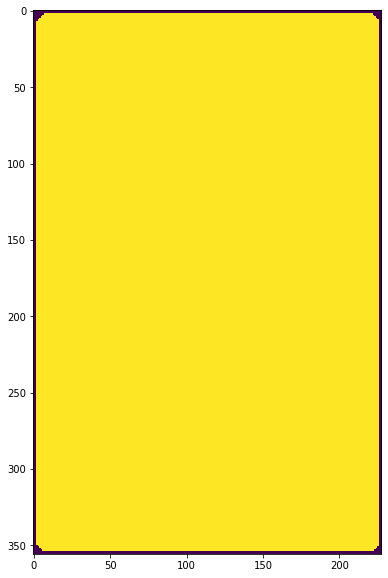

In [5]:
bord_size=2 # bord_size alpha=0
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

74.3679104136949


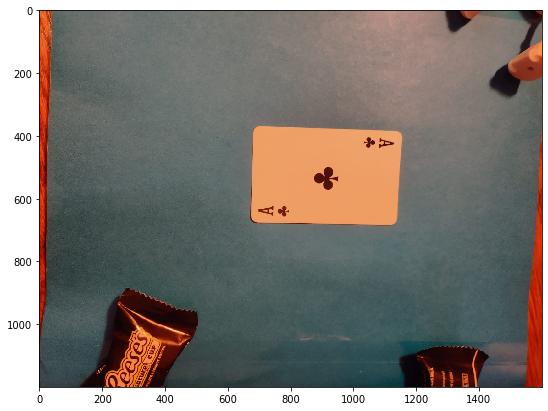

In [6]:
img=cv2.imread("test/ash.jpeg")
display_img(img)
print(cv2.Laplacian(img, cv2.CV_64F).var())

In [10]:
def varianceOfLaplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

img=cv2.imread("test/ash.jpeg")
# display_img(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow("Grayscale", gray)

cv2.startWindowThread()
cv2.namedWindow("grayscale")
cv2.imshow("grayscale", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

# gray = cv2.bilateralFilter(gray,11,17,17)
# cv2.startWindowThread()
# cv2.namedWindow("bilateral")
# cv2.imshow("bilateral", gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
gray = cv2.medianBlur(gray, 5)
cv2.startWindowThread()
cv2.namedWindow("medianblur")
cv2.imshow("medianblur", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

edge = cv2.Canny(gray, 100, 255)
cv2.startWindowThread()
cv2.namedWindow("canny")
cv2.imshow("canny", edge)
cv2.waitKey(0)
cv2.destroyAllWindows()

# valid,card=extract_card(img,"test/extracted_card.png", debug=debug)
# if valid:
#     display_img(card)

major = cv2.__version__.split('.')[0]
if major == '3':
    _, cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
# We suppose that the contour with largest area corresponds to the contour delimiting the card
print(len(cnts))
cnt = max(cnts, key=cv2.contourArea)

cv2.drawContours(gray, cnt, -1, (0,255,0), 3)
cv2.startWindowThread()
cv2.namedWindow("contour")
cv2.imshow("contour", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

54


In [15]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

def extract_card (img, output_fn=None, min_focus=5, debug=False):
    """
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    # Convert in gray color
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Noise-reducing and edge-preserving filter
#     gray=cv2.bilateralFilter(gray,11,17,17)
    median = cv2.medianBlur(gray, 5)
    
    # Edge extraction
    edge=cv2.Canny(median, 80, 240)
    
    # Find the contours in the edged image
    major = cv2.__version__.split('.')[0]
    if major == '3':
        _, cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int0(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)
        
        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)
        
    if debug:
        cv2.imshow("Gray",gray)
        cv2.imshow("Canny",edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[box],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnt],0,(0,255,0),-1)
        cv2.imshow("Contour with biggest area",edge_bgr)
        if valid:
            cv2.imshow("Alphachannel",alphachannel)
            cv2.imshow("Extracted card",imgwarp)

    return valid,imgwarp

84.68362443116212


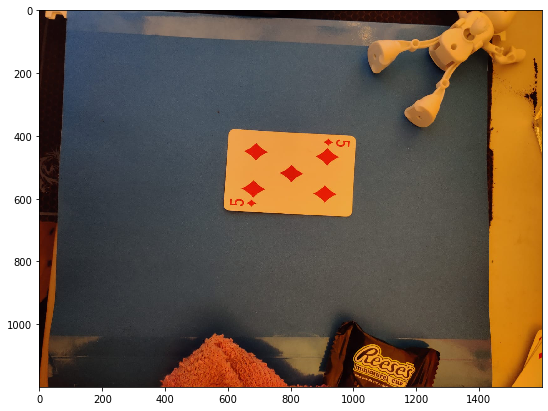

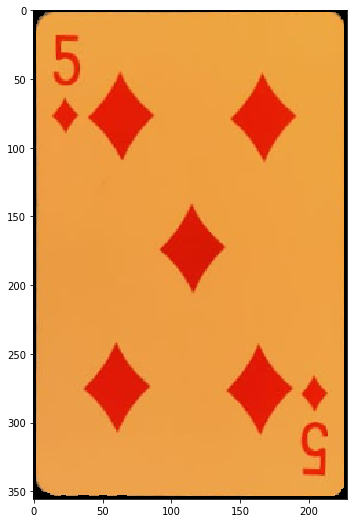

In [21]:
# Test on one image
debug=False
img=cv2.imread("data/Card_Images/Ad2.jpeg")
print(cv2.Laplacian(img, cv2.CV_64F).var())
display_img(img)
valid,card=extract_card(img,"test/extracted_card.png", debug=debug)
if valid:
    display_img(card)
if debug:
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
def extract_cards_from_video(video_fn, output_dir=None, keep_ratio=15, min_focus=120, debug=False):
    """
        Extract cards from media file 'video_fn' 
        If 'output_dir' is specified, the cards are saved in 'output_dir'.
        One file per card with a random file name
        Because 2 consecutives frames are probably very similar, we don't use every frame of the video, 
        but only one every 'keep_ratio' frames
        
        Returns list of extracted images
    """
    if not os.path.isfile(video_fn):
        print(f"Video file {video_fn} does not exist !!!")
        return -1,[]
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cap=cv2.VideoCapture(video_fn)
    
    frame_nb=0
    imgs_list=[]
    while True:
        ret,img=cap.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                output_fn=give_me_filename(output_dir,"png")
            else:
                output_fn=None
            valid,card_img = extract_card(img,output_fn,min_focus=min_focus,debug=debug)
            if debug: 
                k=cv2.waitKey(1)
                if k==27: break
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    
    if debug:
        cap.release()
        cv2.destroyAllWindows()
    
    return imgs_list

In [ ]:
# # video_dir="data/Card Videos"
# extension="jpeg"
# img_dir="data/"
# imgs_dir="data/cards"

# for suit in card_suits:
#     for value in card_values:
        
#         card_name=value+suit
#         for i in range(1, 4):
#             image_fn = os.path.join(img_dir,card_name+str(i)+"."+extension)
#             output_dir=os.path.join(imgs_dir,card_name)
#             output_fn=os.path.join(output_dir+str(i)+"."+extension)
#             if not os.path.isdir(output_dir):
#                 os.makedirs(output_dir)
#             valid,card=extract_card(img, output_fn)
#             if valid:
#                 display_img(card)

In [ ]:
video_dir="data"
extension="jpeg"
imgs_dir="data/cards"

for suit in card_suits:
    for value in card_values:
        
        card_name=value+suit
        for i in range(1, 4):
            video_fn=os.path.join(video_dir,card_name+str(i)+"."+extension)
            output_dir=os.path.join(imgs_dir,card_name)
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            imgs=extract_cards_from_video(video_fn,output_dir)
            print("Extracted images for %s : %d"%(card_name,len(imgs)))

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\garvi\Miniconda3\envs\card\lib\asyncio\selector_events.py", line 114, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] 